#Assignment 4

Artemisia Sarteschi 829677

### Librerie, Import del dataset e Pre-Processing

In [1]:
from google.colab import drive
import json
import os
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from numpy import asarray
from numpy import savetxt

import tensorflow as tf
import cv2                  
from random import shuffle  
from PIL import Image
import random as rn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, make_scorer, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.metrics import accuracy_score
import plotly.express as px
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

Il dataset scelto per questo assigment contiene 4323 immagini in formato colore RGB di 5 tipologia differenti di fiori: girasoli, tulipani, rose, denti di leone e margherite.
Eseguo quindi l'import dei dati e definisco una serie di funzioni per etichettarle con il nome della cartella a cui appartengono e portarle in un medesimo formato (inteso come grandezza) dal momento che presentavano varie dimensioni.

Collego la cartella contente le immagini e le carico: all'interno di X troveremo tutte le immagini e di Z le relative label.

In [2]:
drive.mount('/content/gdrive')
root_dir = "/content/gdrive/MyDrive"
base_dir = root_dir + '/flowers'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
X = []
Z = []
IMG_SIZE = 224
FLOWER_DAISY_DIR = base_dir + '/daisy'
FLOWER_SUNFLOWER_DIR = root_dir + '/flowers/sunflower'
FLOWER_TULIP_DIR = root_dir +  '/flowers/tulip'
FLOWER_DANDI_DIR = root_dir +  '/flowers/dandelion'
FLOWER_ROSE_DIR = root_dir +  '/flowers/rose'

In [4]:
def assign_label(img, flower_type):
    return flower_type

In [5]:
def make_data(flower_type, DIR):
    print("Importing {flower}...".format(flower = flower_type))
    
    for img in os.listdir(DIR):
        try:
            label = assign_label(img, flower_type)
            path = os.path.join(DIR, img)
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            X.append(np.array(img))
            Z.append(str(label))
        except:
            pass
        
    print("### Done ###")

In [6]:
make_data('Daisy', FLOWER_DAISY_DIR)
make_data('Sunflower', FLOWER_SUNFLOWER_DIR)
make_data('Tulip', FLOWER_TULIP_DIR)
make_data('Dandelion', FLOWER_DANDI_DIR)
make_data('Rose', FLOWER_ROSE_DIR)
print("Imported {n} images".format(n = len(X)))

Importing Daisy...
### Done ###
Importing Sunflower...
### Done ###
Importing Tulip...
### Done ###
Importing Dandelion...
### Done ###
Importing Rose...
### Done ###
Imported 4323 images


Formatto le label in formato numerico per poter poi essere utilizzate e riduco la lista delle immagini ad un array.

Successivamente eseguo una permutazione randomica per mischiare le immagini.

In ultimo vado a preprocessare le immagini del dataset con lo stesso preprocessing che hanno ricevuto le immagini di imagenet su cui viene addestrata la rete.

In [7]:
print('Prima dell enconder', Z[1])
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Z)
print('Dopo l enconder', Y[1])
x = np.array(X) 

Prima dell enconder Daisy
Dopo l enconder 0


In [8]:
idx = np.random.permutation(len(X))
x, Y = x[idx], Y[idx]

In [9]:
img_data = preprocess_input(x)
img_data.shape

(4323, 224, 224, 3)

Instazio il dataframe in cui salverò i risultati dell'accuracy della predizione su train e test 

In [10]:
df = pd.DataFrame(columns = ['train','test'])

### EDA

Controllo che le mie classi siano bilanciate o non presentino grosse diferenze di numero e visualizzo alcune immagini.

In [ ]:
plt.figure(figsize = (15, 5))
sns.countplot(Z)

Successivamente le categorie nel grafico avranno la segeunte corrispondeza, categoria:

0. Daisy (margherita)
1. Sunflower (girasole)
2. Tulip (tulipano)
3. Dandelion (dente di leone)
4. Rose (rosa)

Dal grafico precedente possiamo vedere che la categoria dei dandelion sia quella predominante, ma guardando la numerosità la differenza tra le singole numerosità non è tale da comportare difficoltà successive.

In [ ]:
fig, ax = plt.subplots(3, 2, figsize = (30, 30))
fig.set_size_inches(20, 20)
for i in range(3):
    for j in range (2):
        l = rn.randint(0,len(Z))
        ax[i, j].imshow(X[l])
        ax[i, j].set_title('Flower: '+ Z[l])
        
plt.tight_layout()

Elimino le variabili non più necessarie 


In [11]:
del Z
del x

## VGG16

La CNN utilizzata è VGG16 addestrata su imagenet che verrà utilizzata successivamente per fare feature extraction

In [11]:
base_model = VGG16(weights='imagenet', input_shape=(224, 224, 3), )
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Primo taglio

Il primo taglio viene scelto al layer **block4_pool**, un layer di max pooling nel quale le immagini hanno raggiunto un formato 14x14x512. A questo livello della rete per ogni immagine vengono prodotte 100352 features, un numero considerevole. Nei successivi tagli andremo a diminuirne progressivamente il numero avvicinadoci all'out.

Data il formato delle immagini in questo layer è necessario anche applicare un reshaping.

Essendo un taglio non particolarmente vicino all'out non mi aspetto necessariamente una buona performance.

In [14]:
model = Model(inputs = base_model.input, outputs= base_model.get_layer('block4_pool').output)

In [15]:
feature_model = model.predict(img_data)

In [17]:
dims = []
for dim in base_model.get_layer(name = 'block4_pool').output_shape:
  if dim == None:
    pass
  else:
    dims.append(dim)
print(dim)

512


In [18]:
base_model.get_layer(name = 'block4_pool').output_shape

(None, 14, 14, 512)

In [19]:
reshaping = np.prod(np.array(dims))
reshaping

100352

In [20]:
features = feature_model.reshape((feature_model.shape[0], reshaping))
features

array([[  0.       ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       , ...,   0.       ,
          0.       ,  68.17163  ],
       [  0.       ,   0.       ,   6.2711244, ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [  0.       ,   0.       ,   0.       , ...,   0.       ,
          0.       , 212.3743   ],
       [  0.       , 518.87305  ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ]], dtype=float32)

###PCA
Dato che scelgo di utilizzare la Support Vector Machine è necessario scalare i dati tra 0 e 1 per poi eseguire la feature extraction con la PCA, questo per limitare l'impatto delle numerose features sulle prestazioni.

In [21]:
scaler = MinMaxScaler(feature_range=[0, 1])

In [22]:
data_rescaled = scaler.fit_transform(features)
data_rescaled.shape

(4323, 100352)

In [23]:
del features
del dims
del reshaping

In [16]:
pca = PCA(n_components = min(data_rescaled.shape[0], data_rescaled.shape[1]), copy = False).fit(data_rescaled)

Stampo il grafico del risultato della PCA in modo da verificare la somma cumulata della varianza spiegata al crescere delle features selezionate così da poter scegliere un ammontare sensato di features da selezionare.

In [17]:
# plot della pca per scegliere la quanittà
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

Decido di selezionare circa 3000 features così da raccogliere circa l'90% della varianza spiegata ma riducendo il numero di features così da preservare la velocità di calcolo del modello e lo spazio in memoria.

In [18]:
pca = PCA(0.90, copy = False)
dataset = pca.fit_transform(data_rescaled)

del pca
del data_rescaled

dataset.shape

(4323, 2836)

## Train del classificatore

In seguito al preprocessing dei dati e l'esecuzione della PCA, divido il dataset in train e test (75/25)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(dataset, Y, test_size = .25, stratify = Y) 
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3242, 2836), (1081, 2836), (3242,), (1081,))

Per il problema che sono andata ad individuare a seguito di ricerche si rivela più perfomante utilizzare **SVM**, avvio quindi una **Grid Search Cross Validation** per trovare i valori migliori di C e gamma, da prove precedentemente eseguite trovo che il kernel migliore è *rbf*.

In [20]:
param_grid = {'C': [5, 10, 15], 'gamma': ['auto', 'scale']}
svm = GridSearchCV(SVC(class_weight = 'balanced'), param_grid = param_grid, cv = 3, n_jobs = -1)

In [22]:
svm.fit(x_train, y_train)
print("Best C value: {C}\nBest gamma value:{gamma}\n".format(C = svm.best_params_['C'],
                                                           gamma = svm.best_params_['gamma']))
y_pred_train_1 = svm.predict(x_train)
y_pred_1 = svm.predict(x_test)

print(classification_report(y_test, y_pred_1, digits = 3))

Best C value: 15
Best gamma value:scale

              precision    recall  f1-score   support

           0      0.160     0.124     0.140       193
           1      0.241     0.319     0.275       263
           2      0.160     0.117     0.135       196
           3      0.147     0.087     0.110       183
           4      0.243     0.325     0.278       246

    accuracy                          0.210      1081
   macro avg      0.190     0.195     0.188      1081
weighted avg      0.196     0.210     0.198      1081



In [23]:
a = accuracy_score(y_pred_train_1, y_train)
b = accuracy_score(y_pred_1, y_test)
df.loc[0]=[a,b]

La classificazione raggiunge performances molto pessime per quanto il layer sia interno le performance sono peggiori di quanto ci si sarebeb potuto aspettare all'inizio.

Possiamo vedere come la classe su cui i risultati sono migliori sia la classe 1 (girasole) e la peggiore la classe 0 (margherita).

# Secondo Taglio

Il secondo layer scelto per estrarre le  features è **block5_pool** ovvero l'ultimo layer di max pooling della rete, mi aspetto delle performance migliori rispetto al taglio precedente.

A questo punto della rete le nostre immagini hanno raggiunto un formato 7x7x512, quindi più ridotto, per ogni immagine vengono prodotte 25088 features.

Il passaggi eseguiti sono i medesimi del taglio precedente.

In [25]:
model_2 = Model(inputs = base_model.input, outputs= base_model.get_layer('block5_pool').output)

In [26]:
feature_model_2 = model_2.predict(img_data)

In [28]:
dims = []
for dim in base_model.get_layer(name = 'block5_pool').output_shape:
  if dim == None:
    pass
  else:
    dims.append(dim)
print(dim)

512


In [29]:
base_model.get_layer(name = 'block5_pool').output_shape

(None, 7, 7, 512)

In [30]:
reshaping = np.prod(np.array(dims))
reshaping

25088

In [31]:
features = feature_model_2.reshape((feature_model_2.shape[0], reshaping))
features

array([[ 0.       ,  0.       ,  0.       , ...,  0.       , 12.302561 ,
         0.       ],
       [ 0.       ,  0.       , 15.710563 , ...,  0.       , 15.745468 ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
        17.831896 ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  2.0581443,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  2.0469086,
         0.       ]], dtype=float32)

In [32]:
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled_2 = scaler.fit_transform(features)
del feature_model_2
data_rescaled_2.shape

(4323, 25088)

## PCA

In [33]:
pca = PCA(n_components = min(data_rescaled_2.shape[0], data_rescaled_2.shape[1]), copy = False).fit(data_rescaled_2)

In [35]:
exp_var_cumul_2 = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul_2.shape[0] + 1),
    y=exp_var_cumul_2,
    labels={"x": "# Components", "y": "Explained Variance"}
)

Decido di selezionare circa 2000 feature così da raccogliere circa l'90% della varianza spiegata ma riducendo il numero di features così da preservare la velocità di calcolo del modello e lo spazio in memoria.

In [36]:
pca_2 = PCA(0.90, copy = False)
dataset_2 = pca_2.fit_transform(data_rescaled_2)

del pca_2
del data_rescaled_2

dataset_2.shape

(4323, 2239)

## Train del classificatore

In [37]:
x_train, x_test, y_train, y_test = train_test_split(dataset_2,
                                                    Y,
                                                    test_size = .25,
                                                    stratify = Y) 

x_train.shape, x_test.shape, y_train.shape, y_test.shape

del dataset_2

In [38]:
param_grid = {'C': [5, 10, 15], 'gamma': ['auto', 'scale']}

svm = GridSearchCV(SVC(class_weight = 'balanced'),
                   param_grid = param_grid,
                   cv = 3,
                   n_jobs = -1)

In [40]:
svm.fit(x_train, y_train)
print("Best C value: {C}\nBest gamma value:{gamma}\n".format(C = svm.best_params_['C'],
                                                           gamma = svm.best_params_['gamma']))

y_pred_train_2 = svm.predict(x_train)
y_pred_2 = svm.predict(x_test)

print(classification_report(y_test, y_pred_2, digits = 3))

Best C value: 10
Best gamma value:auto

              precision    recall  f1-score   support

           0      0.867     0.845     0.856       193
           1      0.930     0.905     0.917       263
           2      0.805     0.908     0.854       196
           3      0.830     0.825     0.827       183
           4      0.902     0.858     0.879       246

    accuracy                          0.870      1081
   macro avg      0.867     0.868     0.867      1081
weighted avg      0.873     0.870     0.871      1081



In [41]:
a = accuracy_score(y_pred_train_2, y_train)
b = accuracy_score(y_pred_2, y_test)
df.loc[1]=[a,b]

La classificazione raggiunge performances piuttosto buone come ci si aspettava dal momento che il taglio è stato eseguito più vicino all'output rispetto al precedente.

Possiamo vedere come la classe su cui i risultati sono migliori sia la classe 1 (girasole) e le peggiori siano sulla 3 (dente di leone).

# Terzo taglio

L'ultimo taglio è stato scelto al primo layer fully connected *fc1* in cui troviamo 4096 feature per immagine, essendo un taglio molto vicino all'output mi aspetto un buon risultato.



In [12]:
model_3 = Model(inputs = base_model.input, outputs= base_model.get_layer('fc1').output)

In [13]:
feature_model_3 = model_3.predict(img_data)

### PCA 
In questo caso non è necessario fare un reshaping come nei precedenti tagli

In [15]:
scaler = MinMaxScaler(feature_range=[0, 1])

In [16]:
data_rescaled_3 = scaler.fit_transform(feature_model_3)
data_rescaled_3.shape

(4323, 4096)

In [18]:
pca = PCA(n_components = min(data_rescaled_3.shape[0], data_rescaled_3.shape[1]), copy = False).fit(data_rescaled_3)

In [19]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

Decido di selezionare circa 1000 feature così da raccogliere circa l'90% della varianza spiegata ma riducendo il numero di features così da preservare la velocità di calcolo del modello e lo spazio in memoria.

In [20]:
pca = PCA(0.90, copy = False)
dataset_3 = pca.fit_transform(data_rescaled_3)

del pca
del data_rescaled_3

dataset_3.shape

(4323, 1030)

### Train del classificatore

In [21]:
x_train, x_test, y_train, y_test = train_test_split(dataset_3,
                                                    Y,
                                                    test_size = .25,
                                                    stratify = Y) 

x_train.shape, x_test.shape, y_train.shape, y_test.shape

del dataset_3

In [22]:
param_grid = {'C': [5, 10, 15], 'gamma': ['auto', 'scale']}

svm = GridSearchCV(SVC(class_weight = 'balanced'),
                   param_grid = param_grid,
                   cv = 3,
                   n_jobs = -1)

In [23]:
svm.fit(x_train, y_train)
print("Best C value: {C}\nBest gamma value:{gamma}\n".format(C = svm.best_params_['C'],
                                                           gamma = svm.best_params_['gamma']))
y_pred_train_3 = svm.predict(x_train)
y_pred_3 = svm.predict(x_test)

print(classification_report(y_test, y_pred_3, digits = 3))

Best C value: 5
Best gamma value:scale

              precision    recall  f1-score   support

           0      0.891     0.808     0.848       193
           1      0.912     0.905     0.908       263
           2      0.872     0.872     0.872       196
           3      0.870     0.880     0.875       183
           4      0.845     0.907     0.875       246

    accuracy                          0.878      1081
   macro avg      0.878     0.874     0.876      1081
weighted avg      0.879     0.878     0.878      1081



La classificazione raggiunge performances piuttosto buone ma non buona come nel precedentemente taglio, questo può essere dovuto dal fatto che i fully connected layer sono più specifici su imagenet rispetto ai layer precedentemente considerati.

Possiamo vedere come la classe su cui i risultati sono migliori sia la classe 1 (girasole) e le peggiori siano sulla 4 (rose).

In [27]:
a = accuracy_score(y_pred_train_3, y_train)
b = accuracy_score(y_pred_3, y_test)
df.loc[2]=[a,b]

0.877890841813136

# Conclusioni

Stampo un grafico riassuntivo dell'accuratezza nei tre layer considerati.

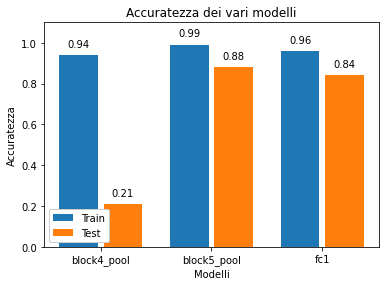

In [53]:
m = ["block4_pool", "block5_pool", "fc1"]
x = np.arange(len(m))

plt.bar(x - 0.2, df["train"], width = 0.35, label = 'Train')
plt.bar(x + 0.2, df["test"], width = 0.35, label = 'Test')

for i in range(len(df)):
    plt.text(x = x[i]-0.3 , y = df["train"].iloc[i]+0.04, s = "%.2f" % df["train"].iloc[i], size = 10)
    plt.text(x = x[i]+0.1 , y = df["test"].iloc[i]+0.04, s = "%.2f" % df["test"].iloc[i], size = 10)
  
plt.xticks(x, m)
plt.ylim(top = 1.1)
plt.xlabel("Modelli")
plt.ylabel("Accuratezza")
plt.title("Accuratezza dei vari modelli")
plt.legend(loc = 'lower left', facecolor='white', framealpha=1)


plt.subplots_adjust(bottom= 0.2, top = 0.98)
plt.show()

Dal grafico è possibile vedere come l'accuratezza sia molto alta sul train e discenda nel test, andando verso l'out le performance migliorano.
fc1 essendo più specifico su imagenet performa leggermente meno bene ma con un accuratezza accettabile.